In [2]:
import os
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from celldreamer.paths import DATA_DIR

from pathlib import Path

In [3]:
raw_dataset_path = DATA_DIR / "raw" / "c_elegans.h5ad"

adata = sc.read(
    raw_dataset_path,
    backup_url="https://github.com/Munfred/wormcells-site/releases/download/packer2019/packer2019.h5ad",
)
adata

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 89701 × 20222
    obs: 'cell', 'numi', 'time_point', 'batch', 'size_factor', 'cell_type', 'cell_subtype', 'plot_cell_type', 'raw_embryo_time', 'embryo_time', 'embryo_time_bin', 'raw_embryo_time_bin', 'lineage', 'passed_qc'
    var: 'gene_id', 'gene_name', 'gene_description'

In [4]:
adata.layers["X_counts"] = adata.X.copy()

In [5]:
sc.pp.filter_genes(adata, min_cells=5)

## Preprocessing 

In [6]:
adata.X.A

array([[ 5.,  0.,  0., ...,  1.,  0.,  0.],
       [20.,  0.,  7., ...,  0.,  0.,  0.],
       [37.,  0., 16., ...,  0.,  0.,  0.],
       ...,
       [18.,  1.,  3., ...,  0.,  0.,  0.],
       [20.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  4., ...,  0.,  0.,  0.]], dtype=float32)

In [48]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


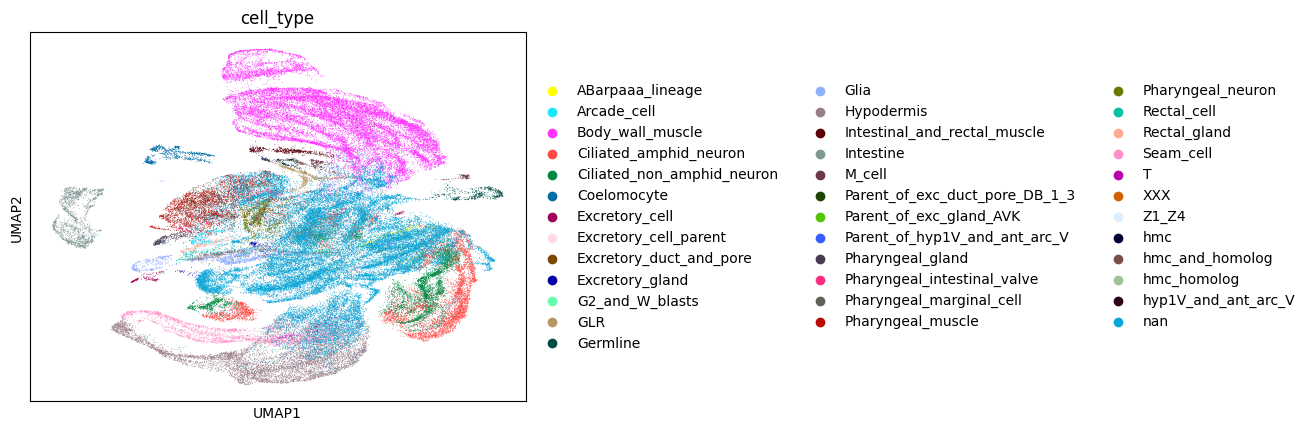

In [49]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="cell_type")

## Train test split 

In [50]:
# Generate random indices for train and test sets
total_samples = adata.n_obs
train_frac = 0.8
train_size = int(total_samples * train_frac)
train_indices = np.random.choice(total_samples, size=train_size, replace=False)
test_indices = np.setdiff1d(np.arange(total_samples), train_indices)

# Separate data into train and test sets by indexing the Anndata object
train_adata = adata[train_indices, :]
test_adata = adata[test_indices, :]

In [51]:
train_adata

View of AnnData object with n_obs × n_vars = 71760 × 17747
    obs: 'cell', 'numi', 'time_point', 'batch', 'size_factor', 'cell_type', 'cell_subtype', 'plot_cell_type', 'raw_embryo_time', 'embryo_time', 'embryo_time_bin', 'raw_embryo_time_bin', 'lineage', 'passed_qc'
    var: 'gene_id', 'gene_name', 'gene_description', 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'distances', 'connectivities'

In [52]:
test_adata

View of AnnData object with n_obs × n_vars = 17941 × 17747
    obs: 'cell', 'numi', 'time_point', 'batch', 'size_factor', 'cell_type', 'cell_subtype', 'plot_cell_type', 'raw_embryo_time', 'embryo_time', 'embryo_time_bin', 'raw_embryo_time_bin', 'lineage', 'passed_qc'
    var: 'gene_id', 'gene_name', 'gene_description', 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'distances', 'connectivities'

In [53]:
adata

AnnData object with n_obs × n_vars = 89701 × 17747
    obs: 'cell', 'numi', 'time_point', 'batch', 'size_factor', 'cell_type', 'cell_subtype', 'plot_cell_type', 'raw_embryo_time', 'embryo_time', 'embryo_time_bin', 'raw_embryo_time_bin', 'lineage', 'passed_qc'
    var: 'gene_id', 'gene_name', 'gene_description', 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'distances', 'connectivities'

## Save

In [54]:
sc.AnnData.write_h5ad(adata, DATA_DIR / "processed_full_genome" / "c_elegans" / "c_elegans.h5ad")

In [55]:
sc.AnnData.write_h5ad(train_adata, DATA_DIR / "processed_full_genome" / "c_elegans" / "c_elegans_train.h5ad")

In [56]:
sc.AnnData.write_h5ad(test_adata, DATA_DIR / "processed_full_genome" / "c_elegans" / "c_elegans_test.h5ad")

## Run highly variable gene selection

In [5]:
adata = sc.read_h5ad(DATA_DIR / "processed_full_genome" / "c_elegans" / "c_elegans.h5ad")
train_adata = sc.read_h5ad(DATA_DIR / "processed_full_genome" / "c_elegans" / "c_elegans_train.h5ad")
test_adata = sc.read_h5ad(DATA_DIR / "processed_full_genome" / "c_elegans" / "c_elegans_test.h5ad")

In [6]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="X_counts",
    subset=False,
)

In [7]:
train_adata.var = adata.var
test_adata.var = adata.var

In [8]:
# sc.AnnData.write_h5ad(adata, DATA_DIR / "processed_full_genome" / "dentategyrus" / "c_elegans.h5ad")
# sc.AnnData.write_h5ad(test_adata, DATA_DIR / "processed_full_genome" / "c_elegans" / "c_elegans_test.h5ad")
# sc.AnnData.write_h5ad(train_adata, DATA_DIR / "processed_full_genome" / "c_elegans" / "c_elegans_train.h5ad")